# Predicting solubility
In this notebook, we are going to predict 
water solubility for some common organic molecules.

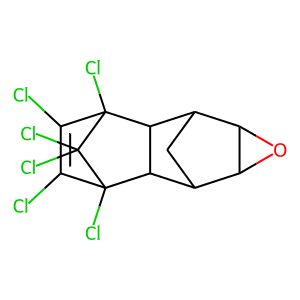

We have solubility data (the logarithm of the solubility in mols per litre) for 1128 molecules. For each molecule, we have calculated around 1100 molecular descriptors. These range from simple ones
(for example, the molecular mass) to more complex ones such as [logP](https://en.wikipedia.org/wiki/Partition_coefficient) (logP is the logarithm of the equilibrium
concentrations of a compound in a mixture of water and 1-octanol 
and measures how hydrophilic or hydrophobic the molecule is).

These descriptors have been calculated with two different libraries, [rdkit](https://www.rdkit.org/) and [mordred](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-018-0258-y).
We have not checked if we have (accidentally) calculated the same descriptor twice (with different names in rdkit/mordred), and many
descriptors are correlated, for instance, the exact molecular weight (based on the IUPAC atomic mass for the most common
isotope of each atom) and the average molecular weight (based on averaging the isotopes for each atom, weighted by natural
fractional abundance of the isotopes).

We will here see how well we can predict the solubility from
the molecular descriptors with three linear models (least squares, PLS, and LASSO).

## Loading the raw data
We start by loading the raw data from the file [solubility_descriptors.csv.zip](./solubility_descriptors.csv.zip):

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
sns.set_theme(style="ticks", context="notebook", palette="muted")

In [ ]:
data = pd.read_csv("solubility_descriptors.csv.zip")
data

Here, we have included the smiles strings for the molecules. We can use this to draw the molecules,
for instance:

In [ ]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

IPythonConsole.ipython_useSVG = True
mol = Chem.MolFromSmiles(data["smiles"].values[1])
mol

In [ ]:
mols = [Chem.MolFromSmiles(i) for i in data["smiles"].values[:9]]
names = [i for i in data["Compound ID"].values[:9]]
Draw.MolsToGridImage(mols, legends=names, subImgSize=(300, 300))

A short description of the different descriptors can be found in the file [descriptors.csv](./descriptors.csv).
We will load it here so we can understand the different variables:

In [ ]:
descriptors = pd.read_csv("descriptors.csv")
descriptors

In [ ]:
# We convert the table above to a dictionary, so that we can pick out descriptions:
descriptors_dict = descriptors.set_index("Descriptor name")[
    "Description"
].to_dict()

Let us now extract the variables we are going to use:

- `smiles` & `Compound ID`: We will ignore these columns (they are just the smiles and the names).


- `measured log solubility in mols per litre`: This is the solubility, and we will use it as our `y`.


- All other variables will be used as `X`.

In [ ]:
yvars = ["measured log solubility in mols per litre"]
ydata = data[yvars].to_numpy()
print(ydata.shape)
skip = ["smiles", "Compound ID"]
xvars = [i for i in data.columns if i not in skip + yvars]
Xdata = data[xvars].to_numpy()
print(Xdata.shape)

## Preprocessing and setting up for train/test

We start by scaling the data and splitting it into training/testing sets:

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    Xdata, ydata, test_size=0.33
)
scale_x = StandardScaler().fit(X_train)
scale_y = StandardScaler().fit(y_train)

X_train = scale_x.transform(X_train)
X_test = scale_x.transform(X_test)

y_train = scale_y.transform(y_train)
y_test = scale_y.transform(y_test)

## Least squares

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
# Create a least squares model here:
# model_least_squares = LinearRegression()

In [ ]:
from fancyplots import mpl_yhat_vs_y

In [ ]:
mpl_yhat_vs_y(
    model_least_squares,
    X_train,
    y_train,
    X_test=X_test,
    y_test=y_test,
    title="Least squares",
)

In [ ]:
from fancyplots import mpl_show_coefficients

mpl_show_coefficients(model_least_squares, xvars, yvars)

In [ ]:
table = pd.DataFrame(
    {
        "Variable": xvars,
        "Coefficient": model_least_squares.coef_.flatten(),
        "Description": [descriptors_dict.get(i, i) for i in xvars],
    }
)
table.sort_values("Coefficient", key=abs, ascending=False)

## Partial Least Squares

In [ ]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GridSearchCV

In [ ]:
# Create the PLS model here:
# model_pls = PLSRegression(...)
# To use grid search:
# parameters = {"n_components": range(1, 16)}
# grid = GridSearchCV(
#    PLSRegression(scale=False),
#    parameters,
#    scoring="r2",
#    cv=10,
#    verbose=3,
# )
# grid.fit(X_train, y_train)
# model_pls = grid.best_estimator_
# model_pls

In [ ]:
mpl_yhat_vs_y(
    model_pls, X_train, y_train, X_test=X_test, y_test=y_test, title="PLS"
)

In [ ]:
mpl_show_coefficients(model_pls, xvars, yvars)

In [ ]:
table = pd.DataFrame(
    {
        "Variable": xvars,
        "Coefficient": model_pls.coef_.flatten(),
        "Description": [descriptors_dict.get(i, i) for i in xvars],
    }
)
table.sort_values("Coefficient", key=abs, ascending=False)

## LASSO

In [ ]:
from sklearn.linear_model import Lasso

In [ ]:
# Create the LASSO model here:
# model_lasso = Lasso(...)
# To do a grid search:
# parameters = {"alpha": np.logspace(-3, 0, 10)}
# grid = GridSearchCV(
#    Lasso(fit_intercept=False, max_iter=10000),
#    parameters,
#    scoring="r2",
#    cv=10,
#    verbose=3,
# )
# grid.fit(X_train, y_train)
# model_lasso = grid.best_estimator_
# model_lasso

In [ ]:
mpl_yhat_vs_y(
    model_lasso, X_train, y_train, X_test=X_test, y_test=y_test, title="LASSO"
)

In [ ]:
mpl_show_coefficients(model_lasso, xvars, yvars)

In [ ]:
table = pd.DataFrame(
    {
        "Variable": xvars,
        "Coefficient": model_lasso.coef_.flatten(),
        "Description": [descriptors_dict.get(i, i) for i in xvars],
    }
)
table.sort_values("Coefficient", key=abs, ascending=False)

Rerun the creation of all three models and observe the results:

- are the models very different each time?

- which of the models do you prefer?

- which one do you think is performing better?

- can you create a better model, for instance, by picking variables that you think are important for the solubility? (Alternatively, you can try a "fancy" gradient boosting regressor such as [CatBoost](https://catboost.ai/))